In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel

/Users/lilianahotsko/Desktop/tartu_4_1/transformers/CryptoBubbles-NAACL-main/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def load_tweets(folder_path):
    tweet_embeddings = {}
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    counter = 0
    for crypto in os.listdir(folder_path):
        if counter <=3:
            crypto_path = os.path.join(folder_path, crypto)
            print(crypto_path)
            if os.path.isdir(crypto_path):  
                embeddings = []
                for file in os.listdir(crypto_path):
                    if file.endswith('.csv'):
                        file_path = os.path.join(crypto_path, file)
                        df = pd.read_csv(file_path)
                        if 'tweet' not in df.columns:
                            continue
                        tweets = df['tweet'].astype(str).tolist()

    
                        inputs = tokenizer(tweets, return_tensors='pt', padding=True, truncation=True, max_length=128)
                        with torch.no_grad():
                            outputs = model(**inputs)
                        tweet_embeds = outputs.last_hidden_state.mean(dim=1)  # Mean over tokens
                        embeddings.append(tweet_embeds.mean(dim=0).numpy())  # Aggregate daily embeddings
                
                if embeddings:
                    tweet_embeddings[crypto] = np.mean(embeddings, axis=0)  # Average across days
                counter += 1
    return tweet_embeddings


In [16]:
def load_price_data(folder_path):
    time_series_data = {}
    scaler = MinMaxScaler()
    counter = 0
    for file in os.listdir(folder_path):
        if counter <=10:
            if file.endswith('.csv'):
                crypto_name = os.path.splitext(file)[0]
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path)
                features = ['low_x', 'high_x', 'open_x', 'close_x', 'volumefrom_x', 'volumeto_x']
                if set(features).issubset(df.columns):
                    df[features] = scaler.fit_transform(df[features])
                    time_series_data[crypto_name] = df[features].values
                counter +=1
    return time_series_data


In [9]:
def align_data(tweet_embeddings, price_data, labels):
    cryptos = set(tweet_embeddings.keys()).intersection(price_data.keys())
    tweet_features = []
    time_features = []
    aligned_labels = []

    for crypto in cryptos:
        tweet_features.append(tweet_embeddings[crypto])
        time_features.append(price_data[crypto][:len(tweet_embeddings[crypto])])
        aligned_labels.append(labels[crypto][:len(tweet_embeddings[crypto])])

    return np.array(tweet_features), np.array(time_features), np.array(aligned_labels)


In [3]:
def load_time_series(file_path):
    df = pd.read_csv(file_path)
    features = ['low_x', 'high_x', 'open_x', 'close_x', 'volumefrom_x', 'volumeto_x']
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    return df


In [10]:
class CryptoDataset(Dataset):
    def __init__(self, tweet_features, time_series, labels):
        self.tweet_features = tweet_features
        self.time_series = time_series
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (torch.tensor(self.tweet_features[idx], dtype=torch.float32),
                torch.tensor(self.time_series[idx], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))


In [11]:
class CombinedModel(nn.Module):
    def __init__(self, text_dim, time_dim, hidden_dim):
        super(CombinedModel, self).__init__()
        self.fc_text = nn.Linear(text_dim, hidden_dim)
        self.fc_time = nn.Linear(time_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim * 2, 1)

    def forward(self, text_features, time_series):
        text_out = torch.relu(self.fc_text(text_features))
        time_out = torch.relu(self.fc_time(time_series))
        combined = torch.cat((text_out, time_out), dim=1)
        output = torch.sigmoid(self.fc_out(combined))
        return output


In [17]:
price_data = load_price_data('data/price_data')

In [18]:
price_data

{'HBAR': array([[0.        , 0.0749275 , 0.        , 0.06519687, 0.02090418,
         0.00360096],
        [0.09139827, 0.08268327, 0.08385683, 0.07091276, 0.03367995,
         0.00638974],
        [0.09728108, 0.0659353 , 0.08945863, 0.07336242, 0.01336238,
         0.00243983],
        ...,
        [0.84163804, 0.71427287, 0.8071883 , 0.7841231 , 0.13104733,
         0.19662959],
        [0.84470491, 0.73630376, 0.7884323 , 0.8063232 , 0.18123067,
         0.27376609],
        [0.77221528, 0.71697053, 0.81018926, 0.72619868, 0.10239891,
         0.14778306]], shape=(556, 6)),
 'IOTA': array([[0.0971885 , 0.0880139 , 0.09611972, 0.0844079 , 0.01685332,
         0.00275412],
        [0.10038339, 0.07695426, 0.0844079 , 0.08677393, 0.00667513,
         0.00103991],
        [0.10115016, 0.08697163, 0.08677393, 0.09606057, 0.00746058,
         0.0012243 ],
        ...,
        [0.90415335, 0.95830921, 0.85626405, 0.95741157, 0.19829879,
         0.202999  ],
        [1.        , 0.9982628

In [21]:
tweet_embeddings = load_tweets('data/tweets')

data/tweets/EOSBULL
data/tweets/CELO


KeyboardInterrupt: 

In [12]:

labels = {crypto: np.random.randint(0, 2, len(price_data[crypto])) for crypto in price_data.keys()}  # Example labels

X_tweets, X_time, y = align_data(tweet_embeddings, price_data, labels)

X_tweets_train, X_tweets_test, X_time_train, X_time_test, y_train, y_test = train_test_split(
    X_tweets, X_time, y, test_size=0.2, random_state=42)


KeyboardInterrupt: 

In [ ]:

train_dataset = CryptoDataset(X_tweets_train, X_time_train, y_train)
test_dataset = CryptoDataset(X_tweets_test, X_time_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = CombinedModel(text_dim=768, time_dim=X_time_train.shape[2], hidden_dim=128)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for tweet_batch, time_batch, label_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(tweet_batch, time_batch).squeeze()
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for tweet_batch, time_batch, label_batch in test_loader:
        preds = model(tweet_batch, time_batch).squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

all_preds = np.array(all_preds)
all_preds_binary = (all_preds > 0.5).astype(int)

print("Classification Report:")
print(classification_report(all_labels, all_preds_binary))


In [26]:
def create_combined_dataset(price_data_folder, tweets_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for crypto_file in os.listdir(price_data_folder):
        if crypto_file.endswith('.csv'):
            crypto_name = os.path.splitext(crypto_file)[0]
            price_file_path = os.path.join(price_data_folder, crypto_file)
            tweet_folder_path = os.path.join(tweets_folder, crypto_name)

            if not os.path.exists(tweet_folder_path):
                print(f"No tweets folder for cryptocurrency: {crypto_name}")
                continue

            price_data = pd.read_csv(price_file_path)
            if 'datetime' not in price_data.columns:
                print(f"'datetime' column missing in price data for {crypto_name}")
                continue

            price_data['datetime'] = pd.to_datetime(price_data['datetime']).dt.date
            combined_data = []

            for _, row in price_data.iterrows():
                date = row['datetime']
                tweet_file = os.path.join(tweet_folder_path, f"{date}.csv")
                if os.path.exists(tweet_file):
                    try:
                        tweets_df = pd.read_csv(tweet_file, engine='python', on_bad_lines='skip')
                        if 'tweet' in tweets_df.columns:
                            tweets_list = tweets_df['tweet'].tolist()
                            row['tweets'] = tweets_list
                        else:
                            row['tweets'] = []
                    except Exception as e:
                        print(f"Error reading {tweet_file}: {e}")
                        row['tweets'] = []
                else:
                    row['tweets'] = []
                combined_data.append(row)

            combined_df = pd.DataFrame(combined_data)
            output_path = os.path.join(output_folder, f"{crypto_name}_combined.csv")
            combined_df.to_csv(output_path, index=False)
            print(f"Combined dataset saved for {crypto_name} at {output_path}")


In [28]:
price_data_folder = "data/price_data"
tweets_folder = "data/tweets"
output_folder = "data/combined_data"

create_combined_dataset(price_data_folder, tweets_folder, output_folder)


Combined dataset saved for HBAR at data/combined_data/HBAR_combined.csv
Combined dataset saved for IOTA at data/combined_data/IOTA_combined.csv
Combined dataset saved for WAN at data/combined_data/WAN_combined.csv
Combined dataset saved for KSM at data/combined_data/KSM_combined.csv
Combined dataset saved for LTO at data/combined_data/LTO_combined.csv
Combined dataset saved for CREAM at data/combined_data/CREAM_combined.csv
Combined dataset saved for OCEAN at data/combined_data/OCEAN_combined.csv
Combined dataset saved for OF at data/combined_data/OF_combined.csv
Combined dataset saved for SASHIMI at data/combined_data/SASHIMI_combined.csv
Combined dataset saved for SAND at data/combined_data/SAND_combined.csv
Combined dataset saved for XRPBULL at data/combined_data/XRPBULL_combined.csv
Combined dataset saved for KTON at data/combined_data/KTON_combined.csv
Combined dataset saved for DMD at data/combined_data/DMD_combined.csv
Combined dataset saved for DRGN at data/combined_data/DRGN_c

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim


In [58]:
def load_combined_data(combined_folder):
    combined_data = []
    counter = 0
    for file in os.listdir(combined_folder):
        if counter <= 10:
            if file.endswith('.csv'):
                file_path = os.path.join(combined_folder, file)
                df = pd.read_csv(file_path)
                df = df.drop(df.columns[[0, 1]], axis=1)
                
                if 'tweets' in df.columns:
                    
                    df['cryptocurrency'] = file.split("_")[0]
                    df['tweets'] = df['tweets'].apply(lambda x: eval(x) if isinstance(x, str) else [])

                columns = ['cryptocurrency'] + [col for col in df.columns if col != 'cryptocurrency']
                df = df[columns]
                combined_data.append(df)
            counter += 1
    return pd.concat(combined_data, ignore_index=True)

combined_folder = "data/combined_data"
combined_df = load_combined_data(combined_folder)


In [59]:
combined_df.columns

Index(['cryptocurrency', 'datetime', 'low_x', 'high_x', 'open_x', 'close_x',
       'volumefrom_x', 'volumeto_x', 'label', 'tweets'],
      dtype='object')

In [60]:
combined_df

,cryptocurrency,datetime,low_x,high_x,open_x,close_x,volumefrom_x,volumeto_x,label,tweets
0,ESS,2018-09-05,0.006400,0.010800,0.009350,0.006412,248484.30,1838.68,0.0,[Top 5 $CDT $BTC on @hitbtc +10% $SOUL $BTC o...
1,ESS,2018-09-06,0.005777,0.007700,0.006412,0.006100,403632.80,2509.71,0.0,"[How Many Essex Property Trust, Inc. $ESS's An..."
2,ESS,2018-09-07,0.006100,0.008000,0.006100,0.006956,1187239.96,8210.72,0.0,[$AIV $AVB $EQR $ESS $UDR https://t.co/uTZePC...
3,ESS,2018-09-08,0.006631,0.007990,0.006956,0.007004,203850.09,1501.02,0.0,[Top 5 $UKG $ETH on @kucoincom +11% $ARN $ETH...
4,ESS,2018-09-09,0.006200,0.007250,0.007004,0.006500,130244.30,878.02,0.0,[Provise Management Group Has Cut Its Lamar Ad...
...,...,...,...,...,...,...,...,...,...,...
6751,SENC,2021-04-03,0.002304,0.002304,0.002304,0.002304,0.00,0.00,0.0,[]
6752,SENC,2021-04-04,0.002304,0.002304,0.002304,0.002304,0.00,0.00,0.0,[ https://t.co/BfcbXSA9tN Use my https://t.c...
6753,SENC,2021-04-05,0.002304,0.002304,0.002304,0.002304,0.00,0.00,0.0,[]
6754,SENC,2021-04-06,0.002304,0.002304,0.002304,0.002304,0.00,0.00,0.0,[]


In [61]:
class CryptoDataset(Dataset):
    def __init__(self, df, features, label_column):

        self.features = df[features].values
        self.labels = df[label_column].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y


In [62]:
class CryptoClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CryptoClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        return x


In [63]:

features = ['low_x', 'high_x', 'open_x', 'close_x', 'volumefrom_x', 'volumeto_x']  # Add more if needed
label_column = 'label'

train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

train_dataset = CryptoDataset(train_df, features, label_column)
test_dataset = CryptoDataset(test_df, features, label_column)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [64]:

input_dim = len(features)
hidden_dim = 128
model = CryptoClassifier(input_dim, hidden_dim)
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for features_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(features_batch).squeeze()
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")


Epoch 1/10, Loss: 2.4395230635781924
Epoch 2/10, Loss: 1.50074885901304
Epoch 3/10, Loss: 1.4978626532076584
Epoch 4/10, Loss: 1.4978166519357239
Epoch 5/10, Loss: 1.500443506913536
Epoch 6/10, Loss: 1.500436010610652
Epoch 7/10, Loss: 1.4977905921156855
Epoch 8/10, Loss: 1.497788243580378
Epoch 9/10, Loss: 1.5004277207121863
Epoch 10/10, Loss: 1.4977849023881031


# Imbalanced data exmaple:

In [65]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features_batch, labels_batch in test_loader:
        preds = model(features_batch).squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

all_preds = (np.array(all_preds) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(all_labels, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1335
         1.0       0.00      0.00      0.00        17

    accuracy                           0.99      1352
   macro avg       0.49      0.50      0.50      1352
weighted avg       0.98      0.99      0.98      1352

Confusion Matrix:
[[1335    0]
 [  17    0]]


/Users/lilianahotsko/Desktop/tartu_4_1/transformers/CryptoBubbles-NAACL-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lilianahotsko/Desktop/tartu_4_1/transformers/CryptoBubbles-NAACL-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lilianahotsko/Desktop/tartu_4_1/transformers/CryptoBubbles-NAACL-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

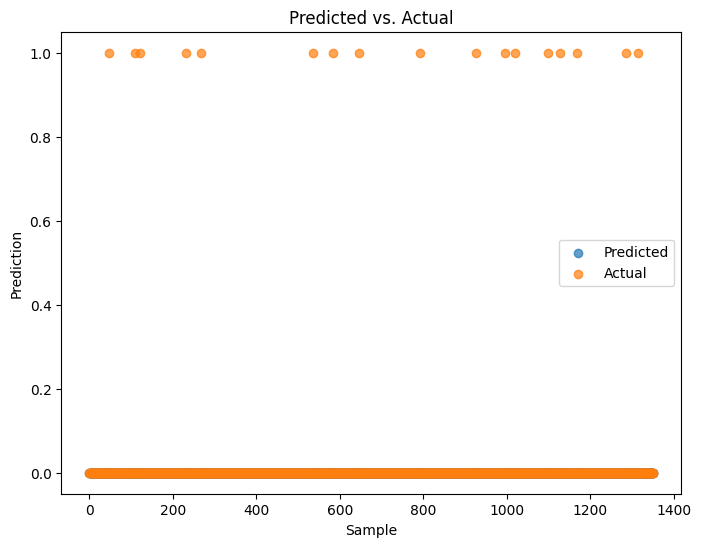

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(range(len(all_preds)), all_preds, label="Predicted", alpha=0.7)
plt.scatter(range(len(all_labels)), all_labels, label="Actual", alpha=0.7)
plt.xlabel("Sample")
plt.ylabel("Prediction")
plt.legend()
plt.title("Predicted vs. Actual")
plt.show()


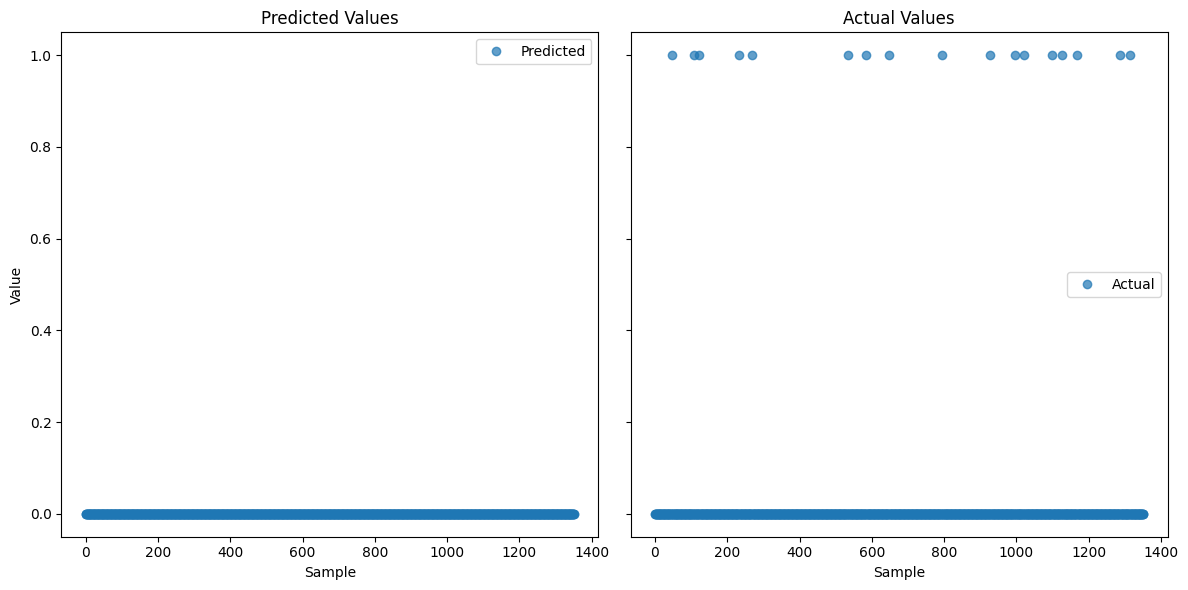

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].plot(range(len(all_preds)), all_preds, 'o', label="Predicted", alpha=0.7)
axes[0].set_title("Predicted Values")
axes[0].set_xlabel("Sample")
axes[0].set_ylabel("Value")
axes[0].legend()

axes[1].plot(range(len(all_labels)), all_labels, 'o', label="Actual", alpha=0.7)
axes[1].set_title("Actual Values")
axes[1].set_xlabel("Sample")
axes[1].legend()

plt.tight_layout()
plt.show()
